<a href="https://colab.research.google.com/github/jinaypanchal/Deep-Learning-Architecture-and-Hardware-Acceleration/blob/main/Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importing Libraries

In [48]:
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


###### Delta and Batch delta rule has been implemented separately, the classes for test dataset and train dataset are defined separately but, batch delta function has been directly called without using the classes

## Delta Rule

In [49]:
import torch
from torch.utils.data import Dataset

class train_data(Dataset):
    def __init__(self, inputs, targets, learning_rates):
        self.inputs = inputs
        self.targets = targets
        self.learning_rates = learning_rates

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx], self.learning_rates[idx]

class test_data(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

#Calculating MEAN SQUARED ERROR Loss
def calculate_mse(test_data, weights):
    mse = 0.0

    for inputs, target in test_data:
        inputs = torch.tensor(inputs, dtype=torch.float32)
        prediction = torch.sum(inputs * weights)
        mse += (target - prediction) ** 2

    mse /= len(test_data)
    return mse.item()

def delta_rule(train_data, test_data):
    # For this rule we will update the weights after each iteration
    #Initial weight assignment
    weights = torch.tensor([50.0, 50.0, 50.0])
    training_losses = []
    testing_losses = []

    for i in range(len(train_data)):
        print("Iteration: ", i )
        # print(len(train_data))
        inputs, target, learning_rate = train_data[i]
        # print(learning_rate)
        #Converting inputs to Tensor
        inputs = torch.tensor(inputs, dtype=torch.float32)
        prediction = torch.sum(inputs * weights)
        loss = target - prediction
        training_losses.append(loss)

        # Updating weights
        weights = weights + learning_rate * inputs * loss
        print(weights)
        test_loss = calculate_mse(test_data, weights)
        testing_losses.append(test_loss)

    return training_losses, weights, testing_losses




# Define inputs and targets for both train and test datasets
delta_train_inputs = [
    (5.0, 2.0, 4.0),
    (3.0, 3.0, 3.0),
    (0.0, 5.0, 1.0),
    (2.0, 1.0, 2.0),
]

delta_train_targets = [1250.0, 900.0, 350.0, 550.0]
delta_learning_rates = [1/70.0, 1/12.0, 1/27.0, 2/20.0]

delta_test_inputs = [
    (6.0, 1.0, 3.0),
    (2.0, 2.0, 1.0),
    (4.0, 5.0, 0.0),
]

delta_test_targets = [1250.0, 500.0, 850.0]

delta_train_dataset = train_data(delta_train_inputs, delta_train_targets, delta_learning_rates)
delta_test_dataset = test_data(delta_test_inputs, delta_test_targets)

delta_losses, delta_weights, delta_test_losses = delta_rule(delta_train_dataset, delta_test_dataset)

print("Delta Rule Training Losses:", delta_losses)
print("Delta Weights: ", delta_weights)
print("Delta Rule Testing Losses: ", delta_test_losses)

delta_test_mse = calculate_mse(delta_test_dataset, delta_weights)
print("Delta Rule Test MSE: ", delta_test_mse)

# Print final testing MSE for delta rule
# final_test_mse = delta_test_losses[-1]
# print("Final Testing MSE for Delta Rule:", final_test_mse)


Iteration:  0
tensor([100.,  70.,  90.])
Iteration:  1
tensor([130., 100., 120.])
Iteration:  2
tensor([130.0000,  50.0000, 110.0000])
Iteration:  3
tensor([134.0000,  52.0000, 114.0000])
Delta Rule Training Losses: [tensor(700.), tensor(120.), tensor(-270.), tensor(20.)]
Delta Weights:  tensor([134.0000,  52.0000, 114.0000])
Delta Rule Testing Losses:  [37000.0, 11800.0, 5133.33349609375, 1938.6666259765625]
Delta Rule Test MSE:  1938.6666259765625


## Batch Delta Rule

In [50]:

import torch

class train_data(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets
        # self.learning_rates = learning_rates

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

class test_data(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

#Calculating MEAN SQUARED ERROR Loss
def calculate_mse(inputs, targets, weights):
    mse = 0.0

    for i in range(len(inputs)):
        input_data = torch.tensor(inputs[i], dtype=torch.float32)
        prediction = torch.sum(input_data * weights)
        mse += (targets[i] - prediction) ** 2

    mse /= len(inputs)
    return mse.item()


def batch_delta_rule(train_inputs, train_targets, test_inputs, test_targets):
    #For  batch delta rule we will process through dividing the inputs into batch size of 3 and updating the weights after processing each batch,
    # and this will be under one epoch and this process will be repeated for 10 epochs

    # print(len(train_inputs))
    batch_size = 3
    num_epochs = 10
    weights = torch.tensor([50.0, 50.0, 50.0])
    training_losses = [] # Storing the training losses
    testing_losses = []  # Store testing losses after calculating it from MSE


    for epoch in range(num_epochs):
        epoch_loss = 0.0
        print("Current Epoch: ", epoch)

        for batch_start in range(0, len(train_inputs), batch_size):
            change = 0
            batch_end = min(batch_start + batch_size, len(train_inputs))
            batch_losses = []

            for i in range(batch_start, batch_end):

                inputs_batch = train_inputs[i]
                # print(inputs_batch)
                target = train_targets[i]
                inputs_batch = torch.tensor(inputs_batch, dtype=torch.float32)
                # print(inputs_batch)
                prediction = torch.sum(inputs_batch * weights)
                loss = target - prediction
                # print(loss)
                # print(loss * inputs_batch)
                batch_losses.append(loss)
                change += loss * inputs_batch
                # print(change)

            learning_rate = 1 / 100
            weights = weights + learning_rate * change
            # print("Updated Weights: ", weights)

            batch_loss = sum(batch_losses) / len(batch_losses)
            epoch_loss += batch_loss
            # print(batch_loss)
            # print(epoch_loss)

        training_losses.append(epoch_loss)
        test_loss = calculate_mse(test_inputs, test_targets, weights)
        testing_losses.append(test_loss)

    return training_losses, weights, testing_losses

# Define inputs and targets for the batch delta rule
batch_delta_train_inputs = [
    (5.0, 2.0, 4.0),
    (3.0, 3.0, 3.0),
    (0.0, 5.0, 1.0),
    (2.0, 1.0, 2.0),
    (1.0, 0.0, 5.0),
    (4.0, 2.0, 1.0),
    (6.0, 1.0, 1.0),
    (2.0, 3.0, 4.0),
    (7.0, 3.0, 0.0),
    (4.0, 4.0, 2.0),
    (1.0, 5.0, 7.0),
    (5.0, 1.0, 3.0),
]

batch_delta_train_targets = [1250.0, 900.0, 350.0, 550.0, 650.0, 800.0, 1050.0, 850.0, 1200.0, 1000.0, 1100.0, 1100.0]

batch_delta_test_inputs = [
    (6.0, 1.0, 3.0),
    (2.0, 2.0, 1.0),
    (4.0, 5.0, 0.0),
]

batch_delta_test_targets = [1250.0, 500.0, 850.0]

num_epochs = 10
batch_size = 3

batch_delta_losses, batch_delta_weights, batch_delta_test_losses = batch_delta_rule(
    batch_delta_train_inputs, batch_delta_train_targets, batch_delta_test_inputs, batch_delta_test_targets)


print()
print("Batch Delta Final Updated weights: ", batch_delta_weights)
print()
print("Batch Delta Rule Training Losses:", batch_delta_losses)
print()
print("Batch Delta Testing Losses (from MSE): ", batch_delta_test_losses)
print()
print("Testing MSE for Batch Delta:", batch_delta_test_losses[-1])


Current Epoch:  0
Current Epoch:  1
Current Epoch:  2
Current Epoch:  3
Current Epoch:  4
Current Epoch:  5
Current Epoch:  6
Current Epoch:  7
Current Epoch:  8
Current Epoch:  9

Batch Delta Final Updated weights:  tensor([149.6477,  51.2920,  99.1688])

Batch Delta Rule Training Losses: [tensor(554.0490), tensor(25.9034), tensor(7.1928), tensor(1.7505), tensor(0.1590), tensor(-0.2376), tensor(-0.2819), tensor(-0.2367), tensor(-0.1799), tensor(-0.1316)]

Batch Delta Testing Losses (from MSE):  [7274.12646484375, 2984.542236328125, 1477.42138671875, 751.3836059570312, 381.6708984375, 193.2288055419922, 97.62451171875, 49.27012252807617, 24.853933334350586, 12.53415298461914]

Testing MSE for Batch Delta: 12.53415298461914


## Testing Losses Plots for Delta and Batch Delta

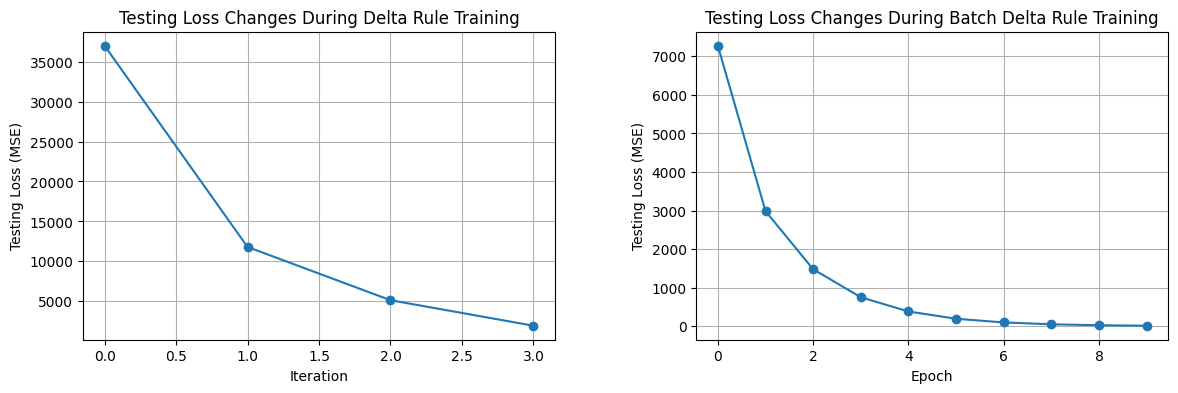

In [51]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(range(len(delta_test_losses)), delta_test_losses, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Testing Loss (MSE)')
plt.title('Testing Loss Changes During Delta Rule Training')
plt.grid(True)
# plt.show()

plt.subplot(1, 2, 2)
plt.plot(range(len(batch_delta_test_losses)), batch_delta_test_losses, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Testing Loss (MSE)')
plt.title('Testing Loss Changes During Batch Delta Rule Training')
plt.grid(True)

plt.subplots_adjust(wspace=0.3)

plt.show()